In [128]:
import pandas as pd
import rdflib
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "ServiceDepartment": [
        {'field': 'name', 'type': 'String'}
    ],
    "Address": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "HealthcareOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle", has_missing=True),
        dedupe.variables.String("name", has_missing=True),
        dedupe.variables.String("birthDate", has_missing=True),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email", has_missing=True)
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber", has_missing=True),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType", has_missing=True)
    ],
    "Department": [
        dedupe.variables.String("name", has_missing=True)
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality", has_missing=True),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode", has_missing=True),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name", has_missing=True)
    ]}





In [129]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph() # Main graph
g1 = rdflib.Graph() # Replaced low graph
g2 = rdflib.Graph() # Train graph
g3 = rdflib.Graph() # Replaced medium graph
g4 = rdflib.Graph() # Replaced high graph
g5 = rdflib.Graph() # Struct low graph
g6 = rdflib.Graph() # Struct high graph
g7 = rdflib.Graph() # Struct train_low graph
g8 = rdflib.Graph() # Struct train_high graph

g.parse("data/healthcare_graph_Main.ttl")
g1.parse("data/healthcare_graph_replaced_low.ttl")
g2.parse("data/healthcare_graph_train.ttl")
g3.parse("data/healthcare_graph_replaced_medium.ttl")
g4.parse("data/healthcare_graph_replaced_high.ttl")
g5.parse("data/healthcare_graph_struct_low.ttl")
g6.parse("data/healthcare_graph_struct_high.ttl")
g7.parse("data/healthcare_graph_train_struct_low.ttl")
g8.parse("data/healthcare_graph_train_struct_high.ttl")
dict_main = kg_to_dedupe_dict(g)
dict_low = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)
dict_medium = kg_to_dedupe_dict(g3)
dict_high = kg_to_dedupe_dict(g4)
dict_struct_low = kg_to_dedupe_dict(g5)
dict_struct_high = kg_to_dedupe_dict(g6)
dict_struct_train_low = kg_to_dedupe_dict(g7)
dict_struct_train_high = kg_to_dedupe_dict(g8)   







def fill_missing_fields(record, required_fields):
    for f in required_fields:
        if f not in record:
            record[f] = None
    return record

def get_type_from_uri(uri):
    # This assumes the type is always in the URI after the domain, e.g. http://example.org/Person/...
    return uri.split('/')[-2] if '/' in uri else None

complete_dicts = {
    "dict_struct_low": dict_struct_low,
    "dict_struct_high": dict_struct_high,
    "dict_struct_train_low": dict_struct_train_low,
    "dict_struct_train_high": dict_struct_train_high
} 
for dict in complete_dicts:
    for uri, record in complete_dicts[dict].items():
        entity_type = get_type_from_uri(uri)
        if entity_type in ENTITY_FIELDS:
            required_fields = [f['field'] for f in ENTITY_FIELDS[entity_type]]
            complete_dicts[dict][uri] = fill_missing_fields(record, required_fields)
        else:
            print(f"Warning: Entity type {entity_type} not found in ENTITY_FIELDS for URI {uri}")




In [130]:
dict_struct_low

{'http://example.org/Person/f31c3d32-0327-4ee9-9df0-2da7feac0b86': {'gender': 'Male',
  'jobTitle': 'Hematologist',
  'knowsLanguage': 'nl',
  'name': 'Carrie Austin',
  'birthDate': None,
  'email': None},
 'http://example.org/ContactPoint/1aecad37-babe-4e22-9286-19a3e23966bd': {'availableLanguage': "['nl']",
  'contactType': 'Staff',
  'email': 'Delgado.Public@dept.healthcare.org',
  'faxNumber': 'nan',
  'telephone': '+31(0)00 9244496'},
 'http://example.org/ServiceDepartment/d118a8e9-2a18-4710-84f8-7624a45d9e73': {'name': 'Geriatric'},
 'http://example.org/Person/3b00c9f5-8a7c-4c14-8047-bed376681d4b': {'gender': 'Male',
  'jobTitle': 'Neurosurgeon',
  'knowsLanguage': 'et',
  'name': 'Kristina Jones',
  'birthDate': None,
  'email': None},
 'http://example.org/ContactPoint/9b297b93-5e9b-48ce-861f-00bf339bf9fe': {'availableLanguage': "['et']",
  'contactType': 'Staff',
  'email': 'Berg.Musculoskeletal@dept.healthcare.org',
  'faxNumber': 'nan',
  'telephone': '(596)958-8188x425'},
 

In [131]:
def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}


person_main = filter_entity(dict_main, "Person")
person_low = filter_entity(dict_low, "Person")
person_medium = filter_entity(dict_medium, "Person")
person_high = filter_entity(dict_high, "Person")
person_struct_low = filter_entity(dict_struct_low, "Person")
person_struct_high = filter_entity(dict_struct_high, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")
train_person_low = filter_entity(dict_struct_train_low, "Person")
train_person_high = filter_entity(dict_struct_train_high, "Person")

contactpoint_main = filter_entity(dict_main, "ContactPoint")
contactpoint_low = filter_entity(dict_low, "ContactPoint")
contactpoint_medium = filter_entity(dict_medium, "ContactPoint")
contactpoint_high = filter_entity(dict_high, "ContactPoint")
contactpoint_struct_low = filter_entity(dict_struct_low, "ContactPoint")
contactpoint_struct_high = filter_entity(dict_struct_high, "ContactPoint")
train_contactpoint_dict1 = filter_entity(train_dict, "ContactPoint")
train_contactpoint_low = filter_entity(dict_struct_train_low, "ContactPoint")
train_contactpoint_high = filter_entity(dict_struct_train_high, "ContactPoint")

address_main = filter_entity(dict_main, "Address")
address_low = filter_entity(dict_low, "Address")
address_medium = filter_entity(dict_medium, "Address")
address_high = filter_entity(dict_high, "Address")
address_struct_low = filter_entity(dict_struct_low, "Address")
address_struct_high = filter_entity(dict_struct_high, "Address")
train_address_dict1 = filter_entity(train_dict, "Address")
train_address_low = filter_entity(dict_struct_train_low, "Address")
train_address_high = filter_entity(dict_struct_train_high, "Address")

hco_main = filter_entity(dict_main, "HealthcareOrganization")
hco_low = filter_entity(dict_low, "HealthcareOrganization")
hco_medium = filter_entity(dict_medium, "HealthcareOrganization")
hco_high = filter_entity(dict_high, "HealthcareOrganization")
hco_struct_low = filter_entity(dict_struct_low, "HealthcareOrganization")
hco_struct_high = filter_entity(dict_struct_high, "HealthcareOrganization")
train_hco_dict1 = filter_entity(train_dict, "HealthcareOrganization")
train_hco_low = filter_entity(dict_struct_train_low, "HealthcareOrganization")
train_hco_high = filter_entity(dict_struct_train_high, "HealthcareOrganization")

sd_main = filter_entity(dict_main, "ServiceDepartment")
sd_low = filter_entity(dict_low, "ServiceDepartment")
sd_medium = filter_entity(dict_medium, "ServiceDepartment")
sd_high = filter_entity(dict_high, "ServiceDepartment")
sd_struct_low = filter_entity(dict_struct_low, "ServiceDepartment")
sd_struct_high = filter_entity(dict_struct_high, "ServiceDepartment")
train_sd_dict1 = filter_entity(train_dict, "ServiceDepartment")
train_sd_low = filter_entity(dict_struct_train_low, "ServiceDepartment")
train_sd_high = filter_entity(dict_struct_train_high, "ServiceDepartment")





In [132]:
person_struct_low

{'http://example.org/Person/f31c3d32-0327-4ee9-9df0-2da7feac0b86': {'gender': 'Male',
  'jobTitle': 'Hematologist',
  'knowsLanguage': 'nl',
  'name': 'Carrie Austin',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/3b00c9f5-8a7c-4c14-8047-bed376681d4b': {'gender': 'Male',
  'jobTitle': 'Neurosurgeon',
  'knowsLanguage': 'et',
  'name': 'Kristina Jones',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/6233637a-ddd2-46e8-b46e-50a463edad22': {'gender': 'Female',
  'jobTitle': 'Reconstructive Specialist',
  'knowsLanguage': 'nl',
  'name': 'Mr. William Flores II',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/e8e0b34b-6f73-4d55-8185-84664e8eba8e': {'gender': 'Female',
  'jobTitle': 'Cardiac Nurse',
  'knowsLanguage': 'nl',
  'name': 'Heather Gardner',
  'birthDate': None,
  'email': None},
 'http://example.org/Person/ad189fba-7626-4533-8bf5-3eda630bbe32': {'gender': 'Male',
  'jobTitle': 'Lab Technician',
  'knowsLanguage': 'nl',


In [133]:
import csv



def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation), converting empty fields to None."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            
            rec1 = {k[5:]: (v if v.strip() != '' else None) for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: (v if v.strip() != '' else None) for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels




matches_Person = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_Person.csv')
distinct_Person = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_Person.csv')
matches_Address = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_Address.csv')
distinct_Address = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_Address.csv')
matches_HealthcareOrganization = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_HealthcareOrganization.csv')
distinct_HealthcareOrganization = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_HealthcareOrganization.csv')
matches_ServiceDepartment = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_ServiceDepartment.csv')
distinct_ServiceDepartment = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_ServiceDepartment.csv')
matches_ContactPoint = read_pairs_from_csv('data/dedupe_data/labelling_train/matches_for_labelling_ContactPoint.csv')
distinct_ContactPoint = read_pairs_from_csv('data/dedupe_data/labelling_train/distinct_pairs_for_labelling_ContactPoint.csv')


# noise = 'high'
# matches_Person = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/matches_for_labelling_Person_{noise}.csv')
# distinct_Person = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/distinct_pairs_for_labelling_Person_{noise}.csv')
# matches_Address = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/matches_for_labelling_Address_{noise}.csv')
# distinct_Address = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/distinct_pairs_for_labelling_Address_{noise}.csv')

# matches_ContactPoint = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/matches_for_labelling_ContactPoint_{noise}.csv')
# distinct_ContactPoint = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/distinct_pairs_for_labelling_ContactPoint_{noise}.csv')

# if noise == 'high':
#     matches_HealthcareOrganization = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/matches_for_labelling_HealthcareOrganization_{noise}.csv')
#     distinct_HealthcareOrganization = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/distinct_pairs_for_labelling_HealthcareOrganization_{noise}.csv')
#     matches_ServiceDepartment = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/matches_for_labelling_ServiceDepartment_{noise}.csv')
#     distinct_ServiceDepartment = read_pairs_from_csv(f'data/dedupe_data/labelling_struct/distinct_pairs_for_labelling_ServiceDepartment_{noise}.csv')



In [134]:
training_data_Person = {
    "match": matches_Person[0],
    "distinct": distinct_Person[0][:50],
}

training_data_Address = {
    "match": matches_Address[0],
    "distinct": distinct_Address[0][:50],}

training_data_HealthcareOrganization = {
    "match": matches_HealthcareOrganization[0],
    "distinct": distinct_HealthcareOrganization[0][:10],}

training_data_ServiceDepartment = {
    "match": matches_ServiceDepartment[0],
    "distinct": distinct_ServiceDepartment[0][:40],}

training_data_ContactPoint = {
    "match": matches_ContactPoint[0],
    "distinct": distinct_ContactPoint[0][:50],}

low and high correspond to training structural dict1 is for consistency

In [135]:
linker_person = dedupe.RecordLink(ENTITY_FIELDS_dedup['Person'])
linker_person.mark_pairs(training_data_Person)
linker_person.prepare_training(person_main, train_person_dict1, sample_size=400)
linker_person.train()

linker_address = dedupe.RecordLink(ENTITY_FIELDS_dedup['PostalAddress'])
linker_address.mark_pairs(training_data_Address)
linker_address.prepare_training(address_main, train_address_dict1, sample_size=400)
linker_address.train()

linker_hco = dedupe.RecordLink(ENTITY_FIELDS_dedup['MedicalOrganization'])
linker_hco.mark_pairs(training_data_HealthcareOrganization)
linker_hco.prepare_training(hco_main, train_hco_dict1, sample_size=400)
linker_hco.train()

linker_sd = dedupe.RecordLink(ENTITY_FIELDS_dedup['Department'])
linker_sd.mark_pairs(training_data_ServiceDepartment)
linker_sd.prepare_training(sd_main, train_sd_dict1, sample_size=400)
linker_sd.train()

linker_contactpoint = dedupe.RecordLink(ENTITY_FIELDS_dedup['ContactPoint'])
linker_contactpoint.mark_pairs(training_data_ContactPoint)
linker_contactpoint.prepare_training(contactpoint_main, train_contactpoint_dict1, sample_size=400)
linker_contactpoint.train()

In [136]:
links_person = linker_person.join(person_main, person_medium, threshold=0.5)
links_address = linker_address.join(address_main, address_medium, threshold=0.5)
links_hco = linker_hco.join(hco_main, hco_medium, threshold=0.5)
links_sd = linker_sd.join(sd_main, sd_medium, threshold=0.5)
links_contactpoint = linker_contactpoint.join(contactpoint_main, contactpoint_medium, threshold=0.5)


In [137]:
pairs_person = [ (str(pair[0][0]), str(pair[0][1])) for pair in links_person ]
pairs_address = [ (str(pair[0][0]), str(pair[0][1])) for pair in links_address ]
pairs_hco = [ (str(pair[0][0]), str(pair[0][1])) for pair in links_hco ]
pairs_sd = [ (str(pair[0][0]), str(pair[0][1])) for pair in links_sd ]
pairs_contactpoint = [ (str(pair[0][0]), str(pair[0][1])) for pair in links_contactpoint ]

In [138]:
extracted_pairs_Person = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links_person
)

extracted_pairs_Address = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links_address
)

extracted_pairs_HCO = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links_hco
)

extracted_pairs_SD = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links_sd
)

extracted_pairs_ContactPoint = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links_contactpoint
)


golden_record_person = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_medium_updated_GT_Person.csv')
test_GT_Person = golden_record_person[['uri1', 'uri2']].values.tolist()

golden_record_address = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_medium_updated_GT_Address.csv')
test_GT_Address = golden_record_address[['uri1', 'uri2']].values.tolist()

golden_record_hco = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_medium_updated_GT_HealthcareOrganization.csv')
test_GT_HCO = golden_record_hco[['uri1', 'uri2']].values.tolist()

golden_record_sd = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_medium_updated_GT_ServiceDepartment.csv')
test_GT_SD = golden_record_sd[['uri1', 'uri2']].values.tolist()

golden_record_contactpoint = pd.read_csv('data/dedupe_data/ground_truths_test/test_golden_standard_medium_updated_GT_ContactPoint.csv')
test_GT_ContactPoint = golden_record_contactpoint[['uri1', 'uri2']].values.tolist()


golden_pairs_Person = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Person
)

golden_pairs_Address = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Address
)

golden_pairs_HCO = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_HCO
)

golden_pairs_SD = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_SD
)

golden_pairs_ContactPoint = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_ContactPoint
)

found_Person = extracted_pairs_Person & golden_pairs_Person
found_Address = extracted_pairs_Address & golden_pairs_Address
found_HCO = extracted_pairs_HCO & golden_pairs_HCO
found_SD = extracted_pairs_SD & golden_pairs_SD
found_ContactPoint = extracted_pairs_ContactPoint & golden_pairs_ContactPoint

In [139]:
found_Person, found_Address, found_ContactPoint

({('0116d36e-bba3-48dc-b6a1-521655d2309b',
   'fbf9c399-b2ec-4a53-977d-3f732c834f74'),
  ('01396d1a-8cec-4b63-b9fd-ae736f40bcfc',
   '64b360a6-3f64-4191-9fca-3dcd65b99688'),
  ('01b7a7c7-d2a9-483e-b3a3-6fc5de974c55',
   'f7f64b10-cd8a-4568-bd4a-05947576b0cb'),
  ('021d14e0-9899-43f4-b54d-f31abc6121cb',
   '8b84f955-a839-45bf-98e5-fd21aad83ba0'),
  ('0362d0d2-a71e-4258-b0bb-d427fb9fe536',
   '18d69e09-8e27-4ca7-8a3d-91181f277020'),
  ('0395edd8-10a0-41e4-81bc-9e48e84ddfc8',
   '74e306a0-9268-467c-974c-010c56d882a5'),
  ('03b08689-1357-4ea1-8cfe-cbc12dcfea01',
   '0f2dc32f-3152-40d3-8743-5101b8501cd6'),
  ('053f06dd-2915-47a9-b4a1-c7ad481214bd',
   'f6101355-5b71-43ce-9703-43a3d04af795'),
  ('057141b1-aabc-451f-bc91-05ee6c752883',
   '30c1df75-2fd8-4a11-8873-95a5b6539ac5'),
  ('059b0583-fde2-4f93-8e6f-1ca7271e2d2f',
   'f3f58070-4ea2-4eac-8c36-67379e831f03'),
  ('06722257-bde3-4232-82d5-afa942d09119',
   'e18505d6-15b3-4641-9e17-b16edf09d0cf'),
  ('06ea3809-a312-4f0d-94e9-9b77fae76dd2',


For completeness noise

In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(found_pairs, golden_pairs):
    # Convert sets to sorted lists for consistent ordering
    found_list = list(found_pairs)
    gold_list = list(golden_pairs)
    # Create a universe of all pairs
    all_pairs = set(found_list) | set(gold_list)
    y_true = [1 if pair in gold_list else 0 for pair in all_pairs]
    y_pred = [1 if pair in found_list else 0 for pair in all_pairs]
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

golden_pairs_Person2 = [
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Person
] + [
    (b.rsplit('/', 1)[-1], a.rsplit('/', 1)[-1])
    for a, b in test_GT_Person]


precision_person, recall_person, f1_person = compute_metrics(extracted_pairs_Person, golden_pairs_Person)
precision_address, recall_address, f1_address = compute_metrics(extracted_pairs_Address, golden_pairs_Address)
precision_hco, recall_hco, f1_hco = compute_metrics(extracted_pairs_HCO, golden_pairs_HCO)
precision_sd, recall_sd, f1_sd = compute_metrics(extracted_pairs_SD, golden_pairs_SD)
precision_cp, recall_cp, f1_cp = compute_metrics(extracted_pairs_ContactPoint, golden_pairs_ContactPoint)

print("Person:     Precision={:.3f} Recall={:.3f} F1={:.3f}".format(precision_person, recall_person, f1_person))
print("Address:    Precision={:.3f} Recall={:.3f} F1={:.3f}".format(precision_address, recall_address, f1_address))
print("HCO:        Precision={:.3f} Recall={:.3f} F1={:.3f}".format(precision_hco, recall_hco, f1_hco))
print("ServiceDept:Precision={:.3f} Recall={:.3f} F1={:.3f}".format(precision_sd, recall_sd, f1_sd))
print("ContactPoint:Precision={:.3f} Recall={:.3f} F1={:.3f}".format(precision_cp, recall_cp, f1_cp))

Person:     Precision=0.967 Recall=1.000 F1=0.983
Address:    Precision=0.797 Recall=1.000 F1=0.887
HCO:        Precision=0.533 Recall=0.667 F1=0.593
ServiceDept:Precision=0.042 Recall=0.044 F1=0.043
ContactPoint:Precision=0.797 Recall=1.000 F1=0.887


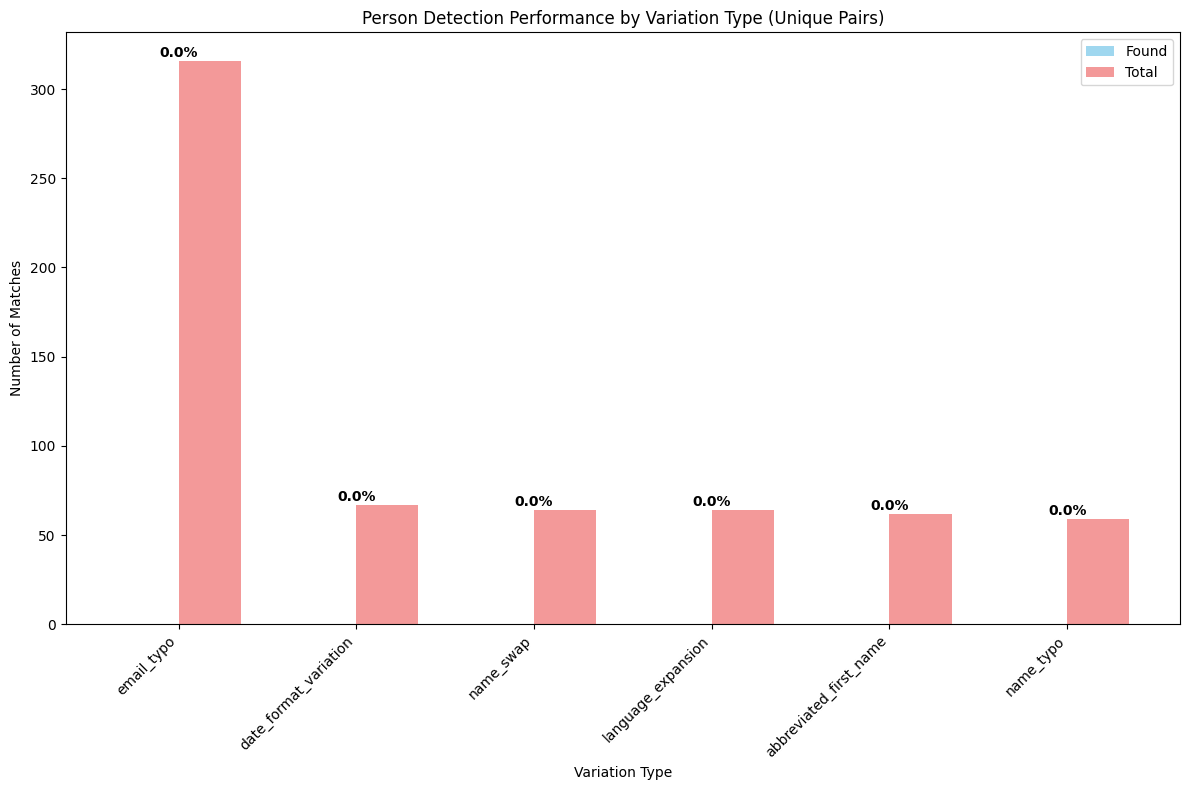

Detection Results by Variation Type:
--------------------------------------------------
email_typo                |   0/316 (  0.0%)
date_format_variation     |   0/ 67 (  0.0%)
name_swap                 |   0/ 64 (  0.0%)
language_expansion        |   0/ 64 (  0.0%)
abbreviated_first_name    |   0/ 62 (  0.0%)
name_typo                 |   0/ 59 (  0.0%)
--------------------------------------------------
Overall Precision: 0.0000
Overall Recall:    0.0000
Overall F1 Score:  0.0000
Overall                   | TP: 0 FP: 395 FN: 382


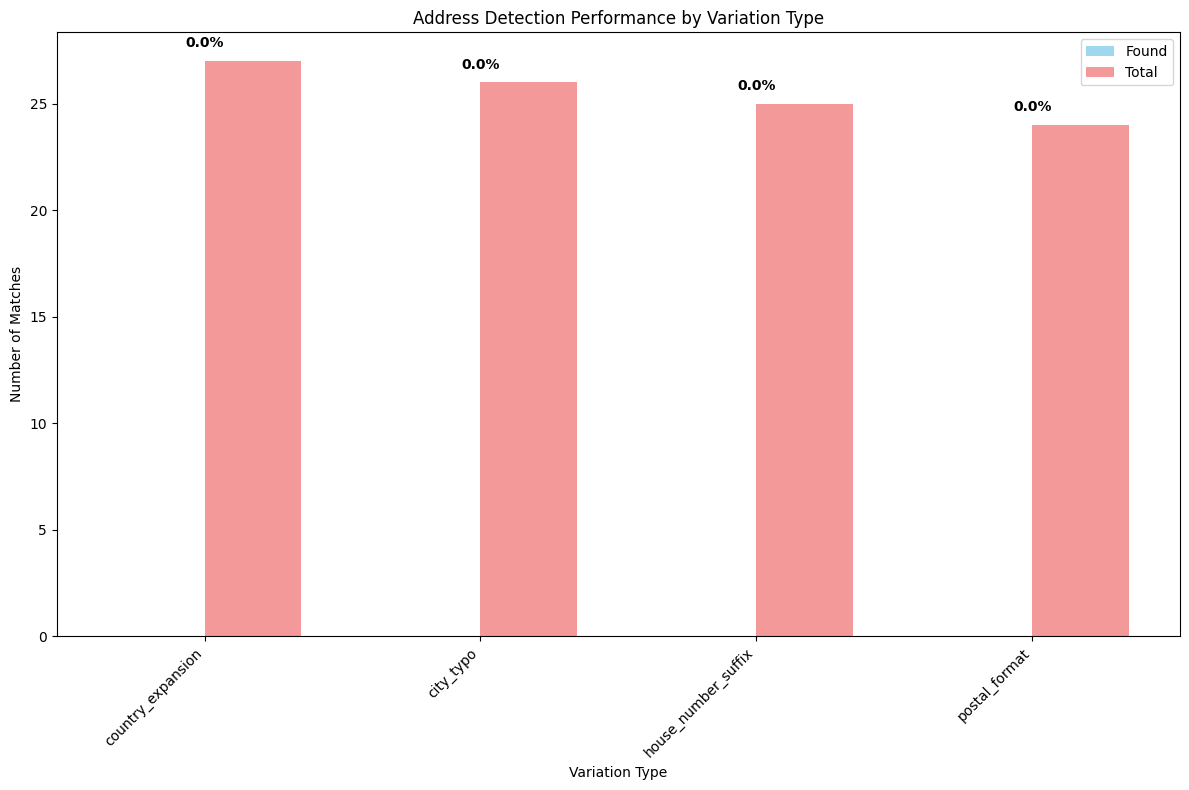

Detection Results by Variation Type:
--------------------------------------------------
country_expansion         |   0/ 27 (  0.0%)
city_typo                 |   0/ 26 (  0.0%)
house_number_suffix       |   0/ 25 (  0.0%)
postal_format             |   0/ 24 (  0.0%)
--------------------------------------------------
Overall Precision: 0.0000
Overall Recall:    0.0000
Overall F1 Score:  0.0000
Overall                   | TP: 0 FP: 102 FN: 102


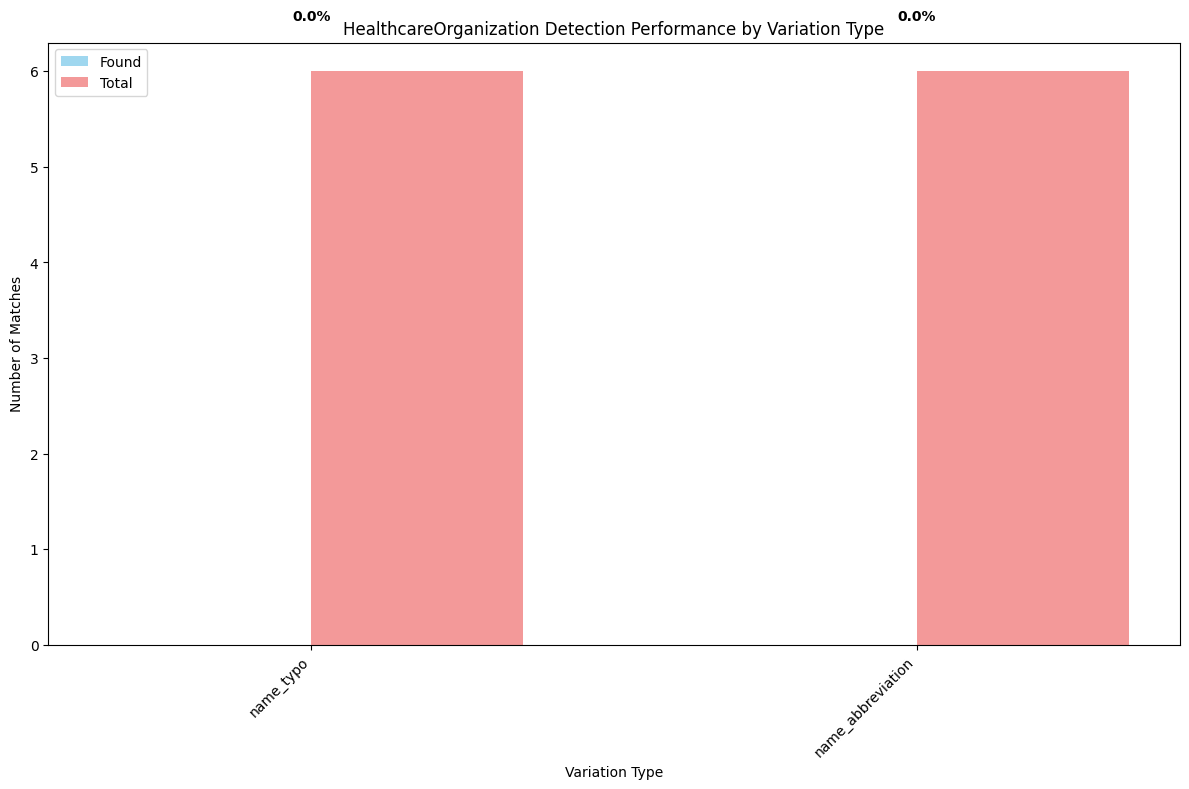

Detection Results by Variation Type:
--------------------------------------------------
name_typo                 |   0/  6 (  0.0%)
name_abbreviation         |   0/  6 (  0.0%)
--------------------------------------------------
Overall Precision: 0.0000
Overall Recall:    0.0000
Overall F1 Score:  0.0000
Overall                   | TP: 0 FP: 8 FN: 12


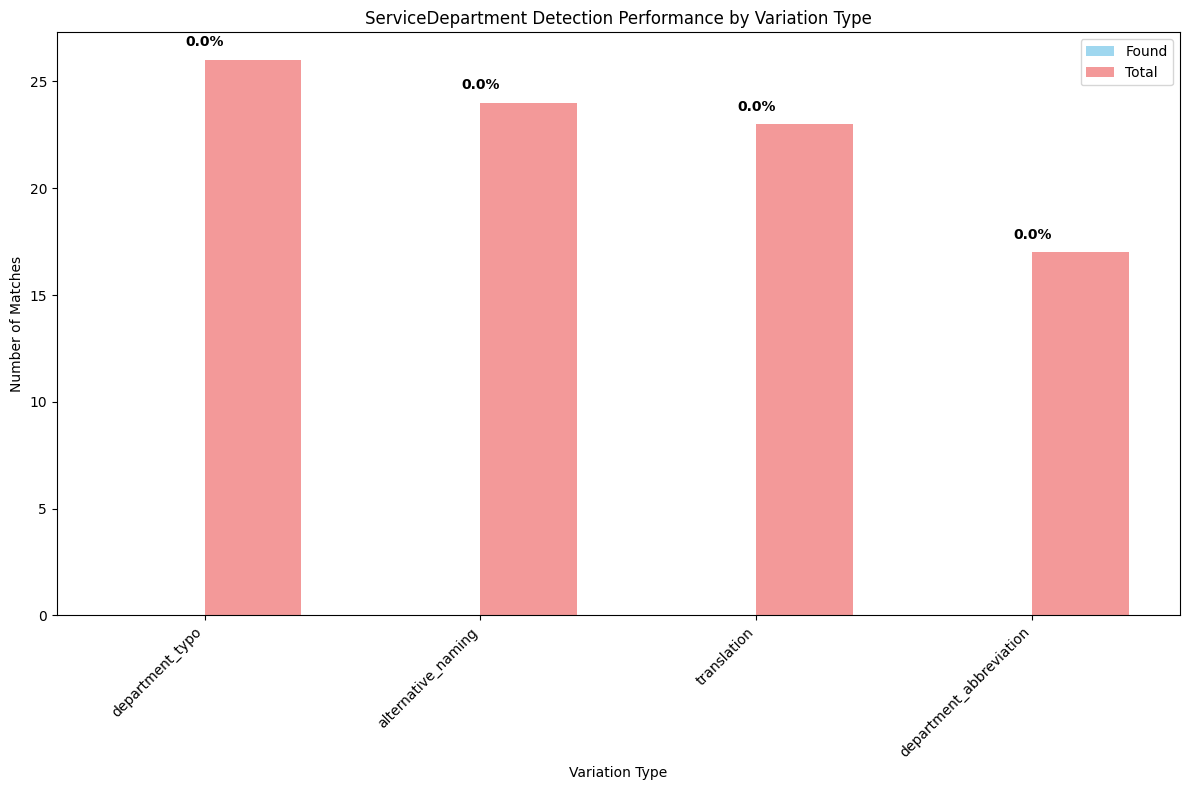

Detection Results by Variation Type:
--------------------------------------------------
department_typo           |   0/ 26 (  0.0%)
alternative_naming        |   0/ 24 (  0.0%)
translation               |   0/ 23 (  0.0%)
department_abbreviation   |   0/ 17 (  0.0%)
--------------------------------------------------
Overall Precision: 0.0000
Overall Recall:    0.0000
Overall F1 Score:  0.0000
Overall                   | TP: 0 FP: 4 FN: 90


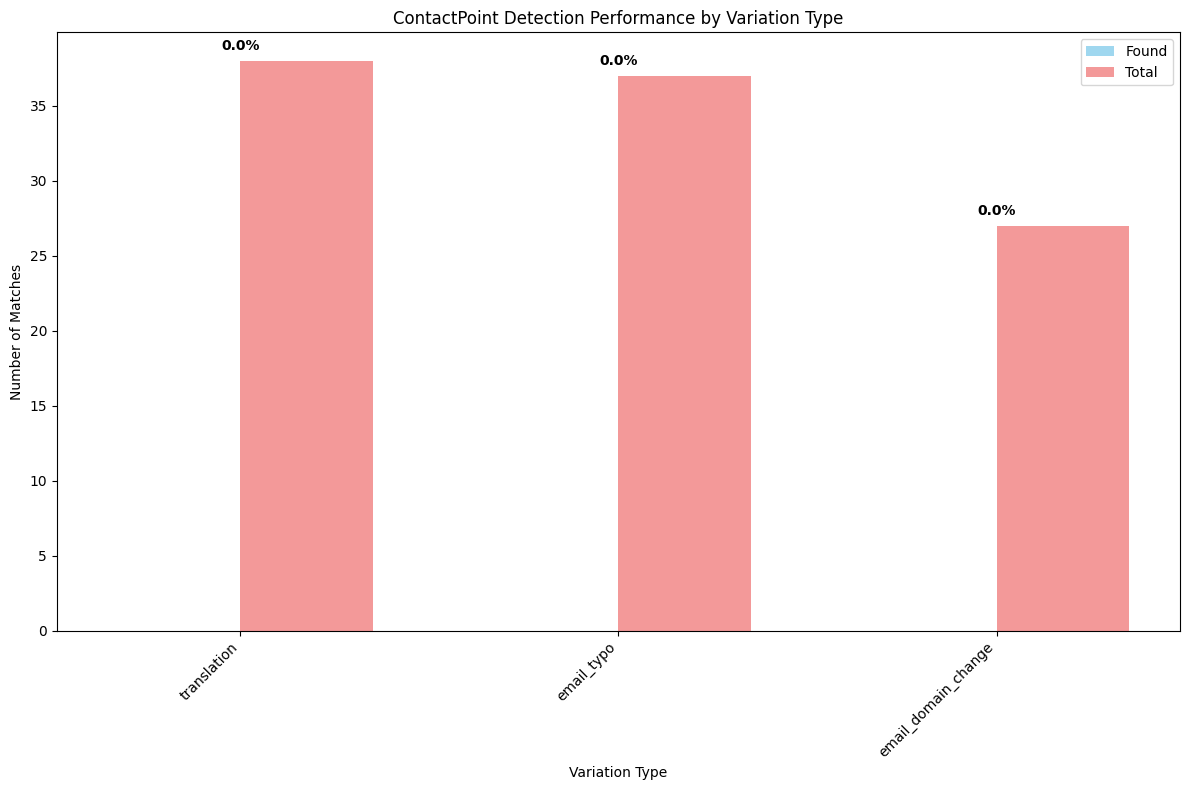

Detection Results by Variation Type:
--------------------------------------------------
translation               |   0/ 38 (  0.0%)
email_typo                |   0/ 37 (  0.0%)
email_domain_change       |   0/ 27 (  0.0%)
--------------------------------------------------
Overall Precision: 0.0000
Overall Recall:    0.0000
Overall F1 Score:  0.0000
Overall                   | TP: 0 FP: 102 FN: 102


(0.0, 0.0, 0)

In [141]:
def plot_detection_by_variation(golden_standard_file, found_pairs, entity_types, title=None):
    import pandas as pd
    import matplotlib.pyplot as plt

    golden_standard = pd.read_csv(golden_standard_file)
    if isinstance(entity_types, str):
        entity_types = [entity_types]
    filtered = golden_standard[golden_standard['entity_type'].isin(entity_types)]

   
        
    gold_set = {tuple(sorted([row['original_id'], row['duplicate_id']])) for _, row in filtered.iterrows()}

    # Variation lookup (for breakdown)
    variation_lookup = {
        tuple(sorted([row['original_id'], row['duplicate_id']])): row['variation_type']
        for _, row in filtered.iterrows()
    }

    # Normalize found pairs
    found_set = {tuple(sorted(pair)) for pair in found_pairs}

    # True positives (correct matches)
    tp_set = found_set & gold_set
    TP = len(tp_set)

    # False positives: found but not in gold
    
    FP = len(found_set) - len(gold_set)

    FP = len(found_set - gold_set)


    # False negatives: in gold, but not found
    FN = len(gold_set - found_set)

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # The rest is your breakdown by variation type
    found_with_variation = {}
    for pair in tp_set:
        vt = variation_lookup[pair]
        found_with_variation[vt] = found_with_variation.get(vt, 0) + 1

    variation_totals = filtered['variation_type'].value_counts().to_dict()
    variation_types = list(variation_totals.keys())
    found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
    total_counts = [variation_totals[vt] for vt in variation_types]
    x = range(len(variation_types))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
    ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

    for i, (found, total) in enumerate(zip(found_counts, total_counts)):
        pct = (found / total * 100) if total else 0
        ax.text(i, max(found, total) + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    ax.set_xlabel('Variation Type')
    ax.set_ylabel('Number of Matches')
    ax.set_title(title if title else 'Detection Performance by Variation Type')
    ax.set_xticks(list(x))
    ax.set_xticklabels(variation_types, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Print results
    print("Detection Results by Variation Type:")
    print("-" * 50)
    for vt in variation_types:
        found = found_with_variation.get(vt, 0)
        total = variation_totals[vt]
        pct = (found / total * 100) if total else 0
        print(f"{vt:25} | {found:3d}/{total:3d} ({pct:5.1f}%)")
    print("-" * 50)
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall:    {recall:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"{'Overall':25} | TP: {TP} FP: {FP} FN: {FN}")

    # Optionally return the scores
    return precision, recall, f1



# Combine and deduplicate (order-insensitive):
combined_pairs = {tuple(sorted(pair)) for pair in found_Person}

plot_detection_by_variation(
    'data/test_golden_standard_high_updated.csv',
    extracted_pairs_Person,
    entity_types=['Person', 'HealthcarePersonnel'],
    title='Person Detection Performance by Variation Type (Unique Pairs)'
)


plot_detection_by_variation(
    'data/test_golden_standard_high_updated.csv',
    found_Address,
    entity_types=['Address'],
    title='Address Detection Performance by Variation Type'
)

plot_detection_by_variation(
    'data/test_golden_standard_high_updated.csv',
    found_HCO,
    entity_types=['HealthcareOrganization'],
    title='HealthcareOrganization Detection Performance by Variation Type'
)

plot_detection_by_variation(
    'data/test_golden_standard_high_updated.csv',
    found_SD,
    entity_types=['ServiceDepartment'],
    title='ServiceDepartment Detection Performance by Variation Type'
)

plot_detection_by_variation(
    'data/test_golden_standard_high_updated.csv',
    found_ContactPoint,
    entity_types=['ContactPoint'],
    title='ContactPoint Detection Performance by Variation Type'
)

In [142]:
# import pandas as pd 
# golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')


# golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
# golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


# ground_truth_test = {}

# # Mapping to Person for both Person and HealthcarePersonnel
# for entity in golden_standard_subset_var['entity_type'].unique():
#     df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
#     entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
#     # Use 'Person' as the key for both types
#     key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
#     if key not in ground_truth_test:
#         ground_truth_test[key] = []
#     ground_truth_test[key].extend([
#         (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
#          f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
#         for _, row in df_filtered.iterrows()
#     ])

# test_GT_Person = ground_truth_test['Person']
# test_GT_HealthcareOrg = ground_truth_test['HealthcareOrg']
# test_GT_ServiceDept = ground_truth_test['ServiceDept']
# test_GT_Address = ground_truth_test['Address']
# test_GT_ContactPoint = ground_truth_test['ContactPoint']

In [143]:
# import random


# def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
#     """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
#     filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
#     all_ids1 = filtered['original_id'].unique()
#     all_ids2 = filtered['duplicate_id'].unique()
#     gt_set = set(ground_truth_pairs)
#     distinct_pairs = set()
#     attempts = 0
#     max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
#     while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
#         a, b = random.choice(all_ids1), random.choice(all_ids2)
#         if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
#             distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
#         attempts += 1
#     return list(distinct_pairs)


# for file in train_gs_files:
#     golden_standard = pd.read_csv(file)
#     golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]
#     entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
#     distinct_pairs = {}
#     for entity_type in entity_types:
#         negatives = sample_distinct_pairs(
#             golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
#         )
#         distinct_pairs[entity_type] = negatives

# DP_Ad = distinct_pairs['Address'][:20]   
# DP_Person = distinct_pairs['Person'][:20]
# DP_HCO = distinct_pairs['HealthcareOrg'][:20]
# DP_SD = distinct_pairs['ServiceDept'][:20]
# DP_CP = distinct_pairs['ContactPoint'][:20]
